# Chapter 6 Linear models and regulatisation

In [54]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise ,
sklearn_selected ,
sklearn_selection_path)
from l0bnb import fit_path

### Forward selection

We will apply the forward-selection approach to the Hitters data. We wish to predict a baseball player’s Salary on the basis of various statistics associated
with performance in the previous year. First of all, we note that the Salary variable is missing for some of the players. The np.isnan() function can be used to identify the missing observations. It returns an array of the same shape as the input vector, with a True for any elements that are missing, and a False for non-missing elements. The sum() method can then be used to count all of the missing elements.

In [43]:
# Load data
df_hitters = load_data('Hitters')
df_hitters.isna().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

We see that Salary is missing for 59 players. The dropna() method of data frames removes all of the rows that have missing values in any variable (by default — see Hitters.dropna?).

In [44]:
df_hitters = df_hitters.dropna();
df_hitters.shape

(263, 20)

In [47]:
# Create dummy variables for some columns
qual = ['League', 'Division', 'NewLeague']

df_hitters = pd.get_dummies(df_hitters, columns=qual)
df_hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,...,325,9,3,700.0,0,1,1,0,0,1
318,492,136,5,76,50,94,12,5511,1511,39,...,313,381,20,875.0,1,0,1,0,1,0
319,475,126,3,61,43,52,6,1700,433,7,...,37,113,7,385.0,1,0,0,1,1,0
320,573,144,9,85,60,78,8,3198,857,97,...,1314,131,12,960.0,1,0,1,0,1,0


#### Define Cp formula

We first choose the best model using forward selection based on Cp (6.2).
This score is not built in as a metric to sklearn. We therefore define a
function to compute it ourselves, and use it as a scorer. By default, sklearn
tries to maximize a score, hence our scoring function computes the negative
Cp statistic.

In [48]:
def nCp(sigma2, estimator, X, Y):
    """Calculate the negative Cp statistic"""
    n, p = X.shape
    Y_hat = estimator.predict(X)
    RSS = np.sum((Y-Y_hat)**2)
    return -(RSS + 2*p*sigma2)/n

We need to estimate the residual variance $\sigma^2$, which is the first argument
in our scoring function above. We will fit the biggest model, using all the
variables, and estimate $\sigma^2$ based on its MSE.

In [49]:
design = MS(df_hitters.columns.drop('Salary')).fit(df_hitters)
Y = np.array(df_hitters['Salary'])
X = design.transform(df_hitters)
sigma2 = OLS(Y,X).fit().scale

I initially got an error running the code above.

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse_output'

 I fixed it by asigning dummy variables to the data set. 

The function sklearn_selected() expects a scorer with just three arguments
— the last three in the definition of $nCp()$ above. We use the function
partial() first seen in Section 5.3.3 to freeze the first argument with our
estimate of $\sigma^2$.

In [50]:
neg_Cp = partial(nCp , sigma2)

We can now use neg_Cp() as a scorer for model selection.
Along with a score we need to specify the search strategy. This is done
through the object Stepwise() in the ISLP.models package. The method
Stepwise.first_peak() runs forward stepwise until any further additions
to the model do not result in an improvement in the evaluation score.
Similarly, the method Stepwise.fixed_steps() runs a fixed number of steps
of stepwise search.

In [51]:
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

We now fit a linear regression model with Salary as outcome using forward selection. To do so, we use the function sklearn_selected() from the ISLP.models package. This takes a model from statsmodels along with a search strategy and selects a model with its fit method. Without specifying a scoring argument, the score defaults to MSE, and so all 19 variables will be selected (output not shown).

In [52]:
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(df_hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division_E',
 'Errors',
 'Hits',
 'HmRun',
 'League_A',
 'NewLeague_A',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

Using neg_Cp results in a smaller model, as expected, with just 10 variables selected.

In [53]:
hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(df_hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division_E',
 'Hits',
 'PutOuts',
 'Walks')

### Choosing among models using the validation set approach and cross-validation.

As an alternative to using Cp, we might try cross-validation to select a model in forward selection. For this, we need a method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the sklearn_selection_path() estimator from ISLP.models. The function cross_val_predict() from ISLP.models computes the cross-validated predictions for each of the models along the path, which we can use to evaluate the cross-validated MSE along the path. Here we define a strategy that fits the full forward selection path. While there are various parameter choices for sklearn_selection_path(), we use the defaults here, which selects the model at each step based on the biggest reduction in RSS.

In [55]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(OLS , strategy)

We now fit the full forward-selection path on the Hitters data and compute the fitted values.

In [56]:
full_path.fit(df_hitters, Y)
Yhat_in = full_path.predict(df_hitters)
Yhat_in.shape

(263, 23)

(50000.0, 250000.0)

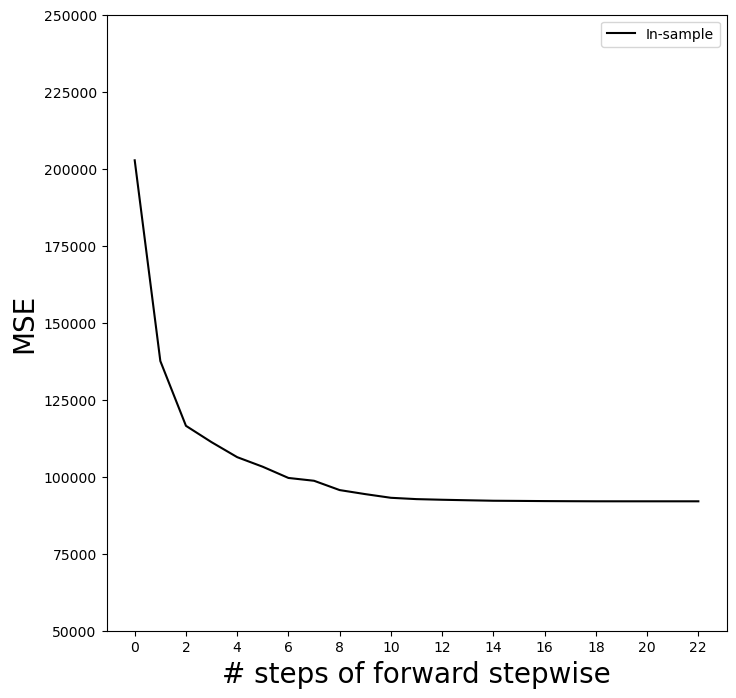

In [57]:
mse_fig , ax = subplots(figsize =(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
insample_mse ,
'k', # color black
label='In-sample')
ax.set_ylabel('MSE',
fontsize =20)
ax.set_xlabel('# steps of forward stepwise',
fontsize =20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim ([50000 ,250000])

Notice the expression None in Y[:,None] above. This adds an axis (dimension)
to the one-dimensional array Y, which allows it to be recycled when
subtracted from the two-dimensional Yhat_in.
We are now ready to use cross-validation to estimate test error along
the model path. We must use only the training observations to perform
all aspects of model-fitting — including variable selection. Therefore, the
determination of which model of a given size is best must be made using
only the training observations in each training fold. This point is subtle but
important. If the full data set is used to select the best subset at each step,
then the validation set errors and cross-validation errors that we obtain
will not be accurate estimates of the test error.
We now compute the cross-validated predicted values using 5-fold crossvalidation.

In [58]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, df_hitters, Y, cv=kfold)
Yhat_cv.shape

(263, 23)

The prediction matrix Yhat_cv is the same shape as Yhat_in; the difference
is that the predictions in each row, corresponding to a particular sample
index, were made from models fit on a training fold that did not include
that row.
At each model along the path, we compute the MSE in each of the crossvalidation
folds. These we will average to get the mean MSE, and can also
use the individual values to compute a crude estimate of the standard error
of the mean.9 Hence we must know the test indices for each cross-validation
split. This can be found by using the split() method of kfold. Because we
fixed the random state above, whenever we split any array with the same
number of rows as Y we recover the same training and test indices, though
we simply ignore the training indices below.

In [59]:
cv_mse = []
for train_idx , test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx ,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(23, 5)

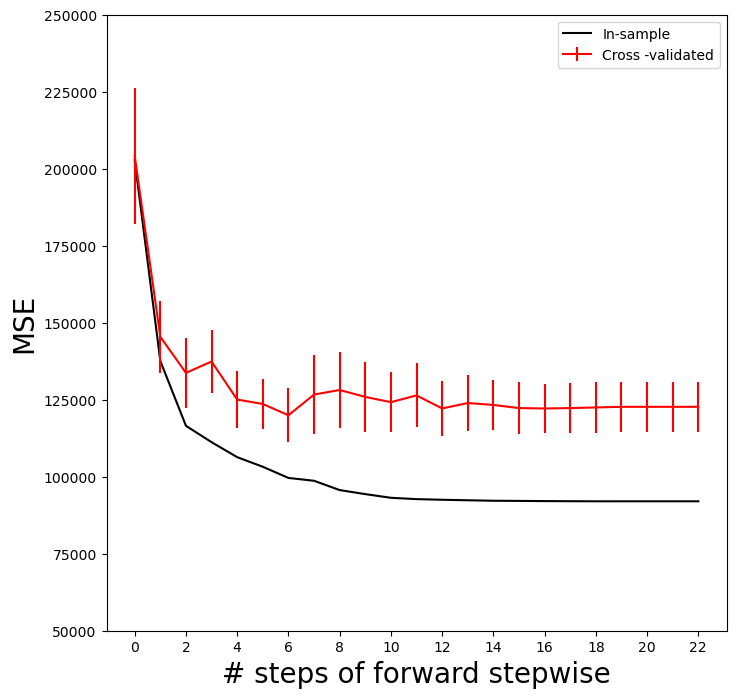

In [60]:
ax.errorbar(np.arange(n_steps),
cv_mse.mean(1),
cv_mse.std(1) / np.sqrt(K),
label='Cross -validated',
c='r') # color red
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig

To repeat the above using the validation set approach, we simply change
our cv argument to a validation set: one random split of the data into a
test and training. We choose a test size of 20%, similar to the size of each
test set in 5-fold cross-validation.

In [61]:
validation = skm.ShuffleSplit(n_splits=1, test_size =0.2, random_state =0)
for train_idx , test_idx in validation.split(Y):
    full_path.fit(df_hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(df_hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx ,None])**2
    validation_mse = errors.mean(0)

As for the in-sample MSE case, the validation set approach does not provide
standard errors.

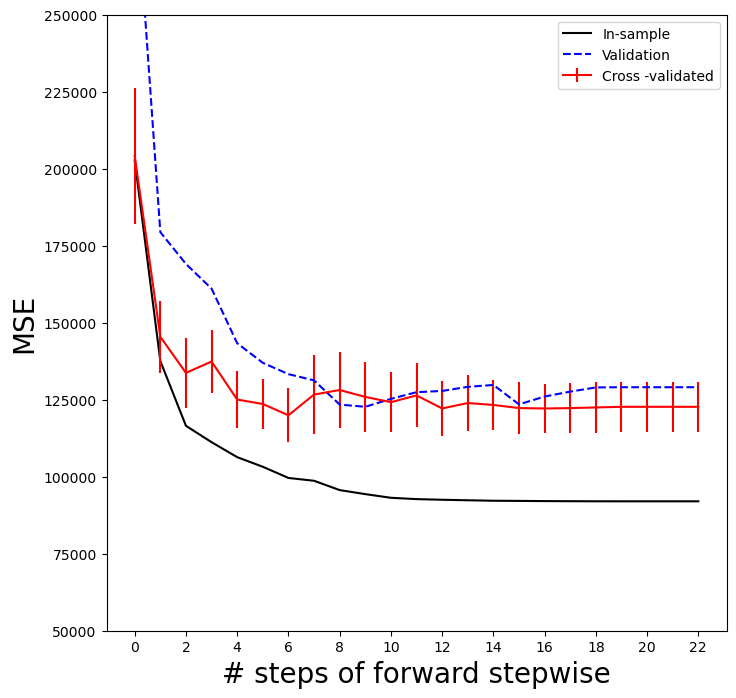

In [62]:
ax.plot(np.arange(n_steps),
validation_mse ,
'b--', # color blue , broken line
label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig